<h1 align="center">*In silico* neuroanatomy of the lateral vs. medial entorhinal cortex</h1>
<h4 align="center">Alex Williams, Nuttida Rungratsameetaweemana, Megan Kirchgessner, Peter Osseward</h4>
<h4 align="center">UC San Diego, Neurosciences Program</h4>

<h3>Differences in Projections to LEC and MEC</h3>

The medial and lateral entorhinal cortex perform distinct functions. Canonically, the medial entorhinal cortex (MEC) contains grid cells and other position-sensitive cells, while cells in the lateral entorhinal cortex (LEC) fire selectively in response to objects. We hypothesized that the MEC and LEC integrate different sources of sensory information to perform these tasks, and tested whether these differences were apparent on an anatomical level in the [Allen Mouse Brain Connectivity Atlas](http://connectivity.brain-map.org/).

In [1]:
from __future__ import division
import urllib
import json
import numpy as np
import pylab as plt
import warnings
warnings.filterwarnings('ignore') # ignore annoying divide by zero warning
%matplotlib inline

**Quantification of Projection Strength.** Because the lateral entorhinal cortex is much larger than the medial entorhinal cortex, we decided to divide the total fluorescence (called `sum` in downloaded dataset) by the size of the target structure (called `num-voxels`), producing a measure of average fluorescence. We studied the logarithm of average fluorescence for two reasons. First, measurements of the average fluorescence typically span orders of magnitude across experiments, making it difficult to compare raw fluorescence across all experiments on the same plot. Second, fluorescence measurements cannot be negative. Taking the logarithm maps the data onto a continuous scale that is more appropriate for statistical analysis.

The cell below calculates the log average fluorescence for all experiments projecting to the medial and lateral entorhinal cortex. These are stored in a list:

    F[target_name][source_name]['vals']

We also keep track of the volume of injected tracer for each experiment in a list:

    F[target_name][source_name]['inj']
    
All data is downloaded using the [Allen Brain Atlas API](http://www.brain-map.org/api/index.html).

In [2]:
base_url = 'http://api.brain-map.org/api/v2/data/query.json?criteria=service::mouse_connectivity_injection_structure'
F = {} # log average fluorescence

def targ_data(targ):
    s = 0    # index for starting row
    done = False
    data = []
    while not done:
        paged_url = base_url+'[target_domain$eq'+targ+'][start_row$eq'+str(s)+']'
        new_data = json.loads(urllib.urlopen(paged_url).read())
        if new_data['num_rows'] == 0:
            done = True
        else:
            data += new_data['msg']
            s += new_data['num_rows']
    return data

for targ_struct in 'ENTm','ENTl':
    data = targ_data(targ_struct)
    F[targ_struct]={}
    for exp in data:
        source_struct = exp['structure-name']
        if source_struct not in F[targ_struct].keys():
            F[targ_struct][source_struct] = {'vals':[],'inj':[],'id':[]}
        avgF = float(exp['sum']) / float(exp['num-voxels'])
        F[targ_struct][source_struct]['vals'].append(np.log(avgF))
        F[targ_struct][source_struct]['inj'].append(float(exp['injection-volume']))
        F[targ_struct][source_struct]['id'].append(exp['id'])

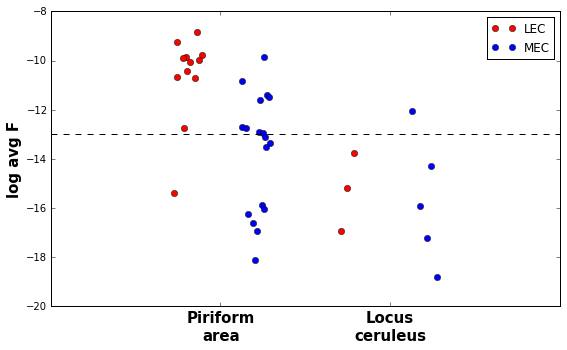

In [3]:
def plot_by_source(source_names):
    n = len(source_names)
    for (xx,name) in enumerate(source_names):
        if name in F['ENTl'].keys():
            Fl = F['ENTl'][name]['vals']
            plt.plot(1+xx+np.random.uniform(-0.3,-0.1,len(Fl)),Fl,'or')
        if name in F['ENTm'].keys():
            Fm = F['ENTm'][name]['vals']
            plt.plot(1+xx+np.random.uniform(0.1,0.3,len(Fm)),Fm,'ob')
    
    frmt_names = [name.replace(' ','\n') for name in source_names]
    plt.xticks(range(1,n+1),frmt_names,fontsize=15,fontweight='bold')
    plt.ylabel('log avg F',fontsize=15,fontweight='bold')
    plt.legend(['LEC','MEC'],loc='upper right')
    plt.xlim([0,n+1])
    
    # values above -13 seem potentially meaningful (set by inspection of raw data)
    plt.plot([0,n+1],-13*np.ones(2),'--k')
    
# Example: plot data for Piriform area and Locus ceruleus
plt.figure(figsize=(8,5))
plot_by_source(['Piriform area','Locus ceruleus'])
plt.tight_layout()
plt.show()

**Statistical Analysis.** We performed [bootstrap t-tests](http://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29) on 2000 bootstrap samples to test whether projection strength to the LEC vs. MEC was significantly different for each source structure. Very few structures showed a significant difference; thus, we decided not to correct for multiple comparisons and used a significance threshold of $\alpha = 0.5$ (two-sided, independent samples). The code below also uses bootstrapping to estimate the effect size for each source structure.

In [4]:
from scipy.stats import ttest_ind,t

def bootstrap_mean_diff(x,y):
    xx = np.random.choice(x,size=len(x),replace=True)
    yy = np.random.choice(y,size=len(y),replace=True)
    if (len(x)+len(y)-2) > 0:
        tstat,pval = ttest_ind(xx,yy)
    else:
        tstat,pval = np.nan,np.nan
    return np.mean(xx)-np.mean(yy),tstat

def est_effect_size(x,y,n=2000):
    estimates,tstats = [],[]
    for i in range(n):
        mean_diff,tstat = bootstrap_mean_diff(x,y)
        estimates.append(mean_diff)
        tstats.append(tstat)
    
    T = np.percentile(tstats,[2.5,97.5])
    df = len(x)+len(y)-2
    pval = min([t.sf(T[0],df),1-t.sf(T[1], df)])
    return np.mean(estimates)/np.std(estimates),pval

# list of injection sites common to both lateral and medial entorhinal cortex
common_sources = list(set(F['ENTl'].keys()) & set(F['ENTm'].keys())) 

N,E,S = [],[],[]
for name in common_sources:
    LEC_data,MEC_data = F['ENTl'][name]['vals'],F['ENTm'][name]['vals']
    N.append(len(LEC_data) + len(MEC_data))
    if N[-1] < 3:
        effect,pval = 0,1.0
    else:
        effect,pval = est_effect_size(LEC_data,MEC_data)
    E.append(effect)
    S.append(pval)
E = np.array(E)

***The following two figures show the ten structures with the largest effect sizes, and smallest p-values, respectively.***

Effect sizes:
	7.88038191306	Nucleus of the lateral olfactory tract
	6.37339169086	Magnocellular nucleus
	5.41390434912	Primary somatosensory area, mouth
	-5.19561297125	Presubiculum
	4.51146355303	Primary motor area
	4.24706434657	Piriform area
	4.06531126654	Gustatory areas
	3.96019506738	Agranular insular area, dorsal part
	3.90122150228	Basomedial amygdalar nucleus, posterior part
	-3.8190874369	Anteromedial nucleus, dorsal part




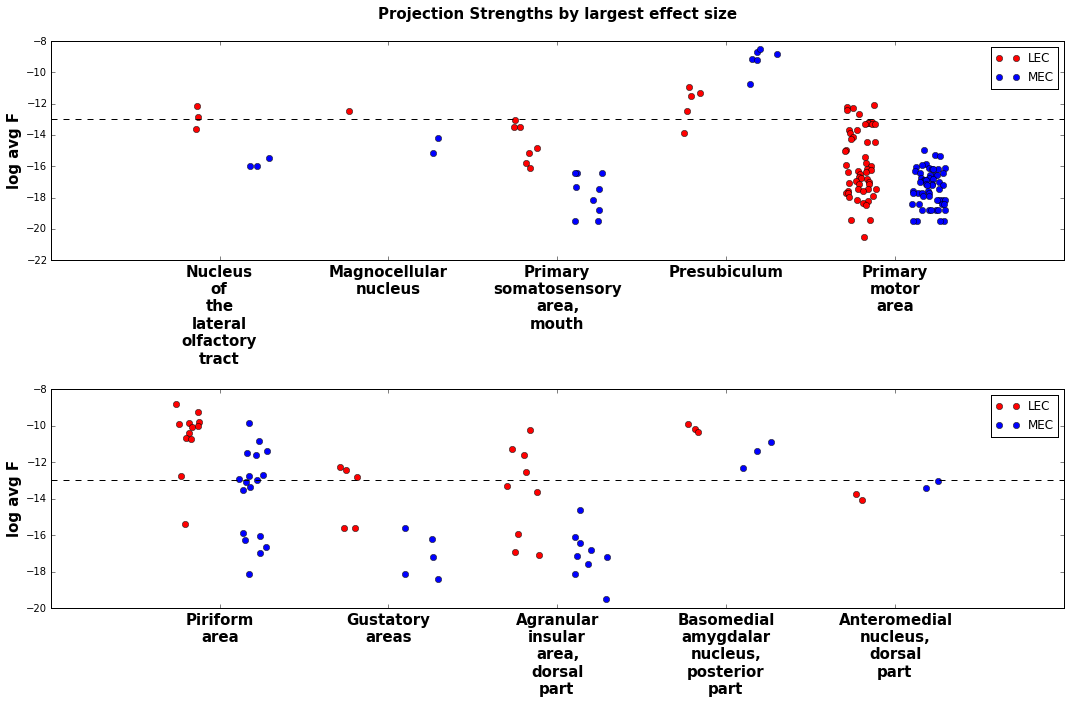

In [5]:
plt.figure(figsize=(15,10))

print 'Effect sizes:'

n_per_plot = 5
n_plots = 2
ii,ss = 0,1
names = [] # structures to plot
for index in np.flipud(np.argsort(np.abs(E))):
    if np.isnan(E[index]) or np.isinf(E[index]):
        continue
    else:
        print '\t'+str(E[index])+'\t'+common_sources[index]
    names.append(common_sources[index])
    if (ii+1) % n_per_plot == 0:
        plt.subplot(n_plots,1,ss)
        plot_by_source(names)
        names = []
        ss += 1
    if ss > n_plots:
        break
    ii += 1

plt.subplot(2,1,1)
plt.title('Projection Strengths by largest effect size\n',fontweight='bold',fontsize=15)
        
plt.tight_layout()
print '\n'
plt.show()

P-values:
	0.000732680833294  	Primary somatosensory area, barrel field
	0.000841769078298  	Supplemental somatosensory area
	0.00124682206751  	Primary somatosensory area, mouth
	0.00401754810417  	Nucleus of the lateral olfactory tract
	0.00449404614432  	Presubiculum
	0.00451827704737  	Primary motor area
	0.00977686191014  	Secondary motor area
	0.021781253738  	Primary somatosensory area, unassigned
	0.0296330917047  	Gustatory areas
	0.0321954988552  	Piriform area




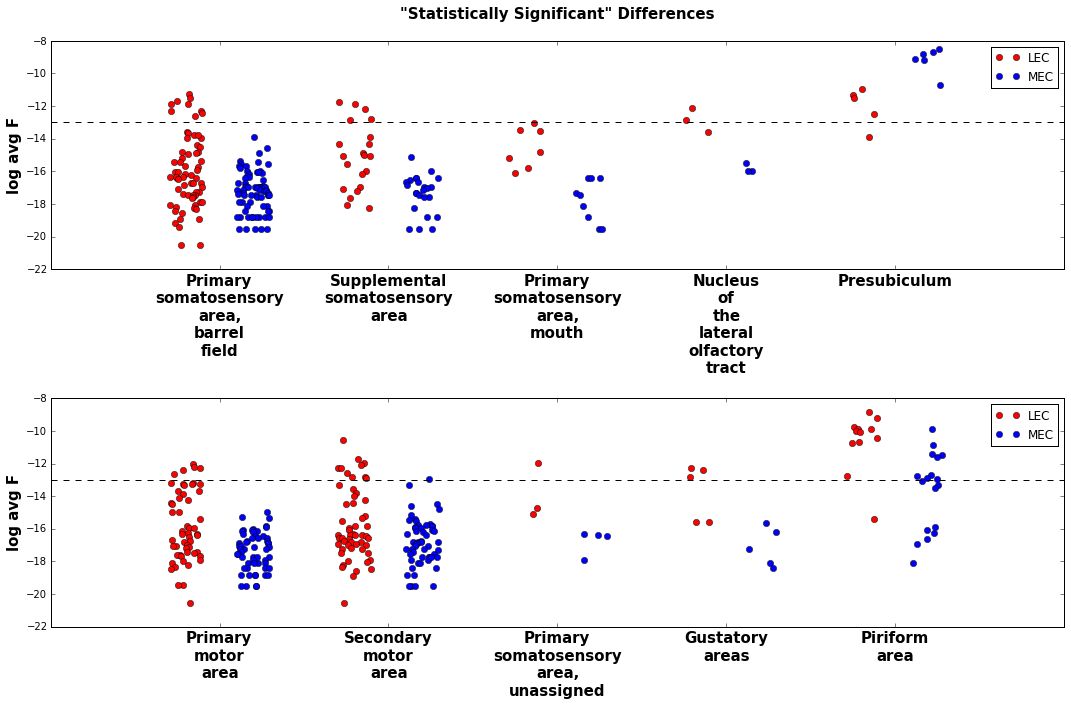

In [6]:
plt.figure(figsize=(15,10))

print 'P-values:'

n_per_plot = 5
n_plots = 2
ii,ss = 0,1
names = [] # structures to plot
for index in np.argsort(S):
    print '\t'+str(S[index])+'  \t'+common_sources[index]
    names.append(common_sources[index])
    if (ii+1) % n_per_plot == 0:
        plt.subplot(n_plots,1,ss)
        plot_by_source(names)
        names = []
        ss += 1
    if ss > n_plots:
        break
    ii += 1

plt.subplot(2,1,1)
plt.title('"Statistically Significant" Differences\n',fontweight='bold',fontsize=15)  
plt.tight_layout()
print '\n'
plt.show()

The injection volume is significantly correlated with target fluorescence only in a subset of structures
--------------

The experiments in the connectivity atlas use a range of injection volumes, creating a potential confound in the above analysis. To explore this, we plotted the correlation coefficient between the injected volume and normalized target fluorescence between each source structure and the MEC/LEC. Surprisingly, the injection volume was strongly correlated target fluorescence in only a subset of source structures. Thus, it was difficult to normalize the above analysis for injection volume; although we would like to take this correlation into account in future analyses.

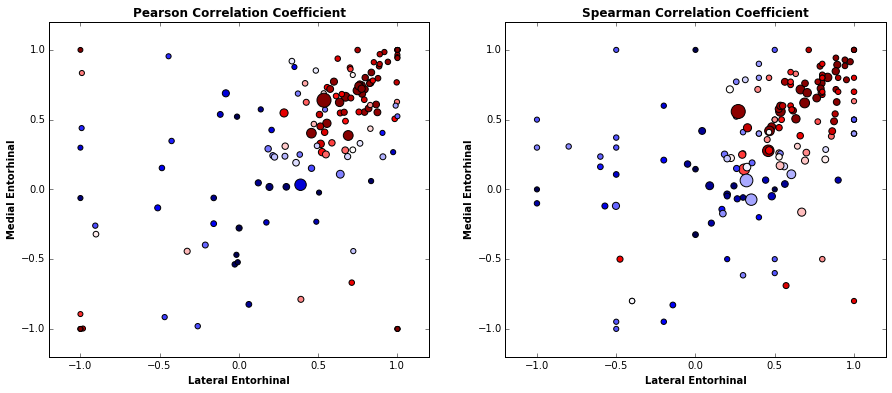

In [7]:
from scipy.stats import pearsonr,spearmanr
from matplotlib.pyplot import cm

plt.figure(figsize=(15,6))
s = 1
for corrfunc in pearsonr,spearmanr:
    plt.subplot(1,2,s)
    s += 1
    lec_corr,mec_corr,pvals,nn = [],[],[],[]
    for name in common_sources:
        r1,p1 = corrfunc(F['ENTl'][name]['inj'],F['ENTl'][name]['vals'])
        r2,p2 = corrfunc(F['ENTm'][name]['inj'],F['ENTm'][name]['vals'])
        if np.any(np.isnan([p1,p2])): continue
        lec_corr.append(r1)
        mec_corr.append(r2)
        pvals.append(max([p1,p2]))
        nn.append(len(F['ENTl'][name]['inj'])+len(F['ENTm'][name]['inj']))
    pvals,lec_corr,mec_corr,nn = np.array(pvals),np.array(lec_corr),np.array(mec_corr),np.array(nn)
    plt.scatter(lec_corr,mec_corr,c=pvals,cmap=cm.seismic_r,clim=[-max(pvals)+0.05,max(pvals)+0.05],s=nn+20)
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.xlabel('Lateral Entorhinal',fontweight='bold')
    plt.ylabel('Medial Entorhinal',fontweight='bold')

plt.subplot(1,2,1)
plt.title('Pearson Correlation Coefficient',fontweight='bold')
plt.subplot(1,2,2)
plt.title('Spearman Correlation Coefficient',fontweight='bold')
plt.show()

**Legend**: The Pearson *(Left)* and Spearman *(Right)* correlation coefficients between injection volume and normalized target fluorescence. The color of each dot represents the significance (p-value) of the calculated correlation coefficient (red, p < 0.05; white, p = 0.05; blue, p > 0.05). The size of each dot denotes the number of replications for each experiment.

Note that there is not always a strong correlation between injection volume and log average fluorescence in each target structure (blue dots in the middle of the plot). Furthermore, structures with a correlation between injection volume and target fluorescence tend to share this correlation for both LEC and MEC (red dots in upper right corner). One potential explanation is that injection volume and target fluorescence are correlated more strongly for nearby anatomical structures through spillover/leak of the tracer.

<h3>Differences in Projections *from* LEC and MEC</h3>

We performed some preliminary analysis to explore the differential projection patterns of the LEC and MEC. Rather than comparing average fluorescence across annotated brain structures (as in the previous section), we used the [3D expression grid data](http://help.brain-map.org//display/api/Downloading+3-D+Expression+Grid+Data) provided by the Allen Institute. This allowed us to create images that directly show differences in projection strength.

The cell below uses the API to download the experimental IDs and injection coordinates for all anterograde tracing experiments originating in the MEC and LEC.

In [8]:
base_url = 'http://api.brain-map.org/api/v2/data/query.json?criteria=service::mouse_connectivity_injection_structure'
def source_data(source):
    s = 0    # index for starting row
    done = False
    data = []
    while not done:
        paged_url = base_url+'[injection_structures$eq'+source+'][start_row$eq'+str(s)+']'
        new_data = json.loads(urllib.urlopen(paged_url).read())
        if new_data['num_rows'] == 0:
            done = True
        else:
            data += new_data['msg']
            s += new_data['num_rows']
    return data

IDs,INJ = {},{} # experiment id numbers, and injection coordinates
for source_struct in 'ENTm','ENTl':
    data = source_data(source_struct)
    IDs[source_struct]=[]
    INJ[source_struct]=[]
    for exp in data:
        IDs[source_struct].append(str(exp['id']))
        INJ[source_struct].append(exp['injection-coordinates'])

# All experimental ids and injection coordinates
all_ids = IDs['ENTm']+IDs['ENTl']
all_coordinates = INJ['ENTm']+INJ['ENTl']

# Convert coordinates to 2d numpy arrays
INJ['ENTm'],INJ['ENTl'] = np.array(INJ['ENTm']),np.array(INJ['ENTl'])
all_coordinates = np.array(all_coordinates)

The cell below plots the (x,y,z) position of the injection coordinates for each experiment. We used the first principal component of this cloud of points to approximate the medial-lateral axis of the entorhinal cortex (second plot below). 

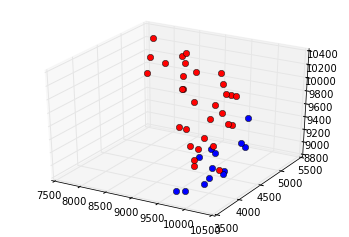

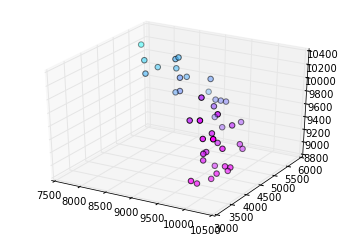

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(INJ['ENTm'][:,0],INJ['ENTm'][:,1],INJ['ENTm'][:,2],'ob')
ax.plot(INJ['ENTl'][:,0],INJ['ENTl'][:,1],INJ['ENTl'][:,2],'or')

model = PCA(n_components=1)
lm_position = model.fit_transform(all_coordinates)
lm_order = np.argsort(lm_position.flatten())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_coordinates[:,0],all_coordinates[:,1],zs=all_coordinates[:,2],c=lm_position,cmap=cm.cool,s=30)
plt.show()

***The cell below downloads the 3D expression grid data for the LEC and MEC using the API, and averages the grid expression across all experiments.***

In [10]:
import zipfile
from StringIO import StringIO
import urllib
from struct import unpack

def get_grid_dims(expID):
    # Download a dataset (in the future, iterate over many datasets)
    pagedUrl = 'http://api.brain-map.org/grid_data/download/'+expID+'?include=density'
    expzipfile = zipfile.ZipFile(StringIO(urllib.urlopen(pagedUrl).read()))

    # Extract dimensions of 3D grid
    with expzipfile.open('density.mhd','r') as f:
        for line in f.readlines():
            if line[:7] == 'DimSize':
                dims = [int(d) for d in line[10:].split(' ')]
    dims.reverse()
    return dims

def get_grid_data(expID):
    pagedUrl = 'http://api.brain-map.org/grid_data/download/'+expID+'?include=density'
    expzipfile = zipfile.ZipFile(StringIO(urllib.urlopen(pagedUrl).read()))

    ## Read the density.raw file
    # There should be 4 characters '\xhh\xhh\xhh\xhh' for each 32-bit number
    with expzipfile.open('density.raw','r') as f:
        lines = f.readlines()
        s = ''.join(lines)  # turn file into one large string. What are the newlines for in the original file?
        density = unpack('<%df'%(len(s)/4),s)

    # map -1 to zero
    density = np.array(density)
    density[density < 0] *= 0

    # Make 3D arrays of intensity, density, and expression
    D = np.reshape(density,tuple(dims))

    return D

dims = get_grid_dims(IDs['ENTm'][0]) # xyz dimensions of grid

print 'fetching medial datasets....'
grid_medial = np.zeros(dims+[len(IDs['ENTm'])])
for i,expid in enumerate(IDs['ENTm']):
    grid_medial[:,:,:,i] += get_grid_data(expid)
avg_grid_medial = np.mean(grid_medial,axis=3)

print 'fetching lateral datasets....'
grid_lateral = np.zeros(dims+[len(IDs['ENTl'])])
for i,expid in enumerate(IDs['ENTl']):
    grid_lateral[:,:,:,i] += get_grid_data(expid)
avg_grid_lateral = np.mean(grid_lateral,axis=3)

all_grid_data = np.concatenate((grid_medial,grid_lateral), axis=3)

fetching medial datasets....
fetching lateral datasets....


***The cell below plots maximal projections of the average grid expression data in sagittal, horizontal, and coronal sections. One notable difference is that the MEC has stronger contralateral projections than the LEC.***

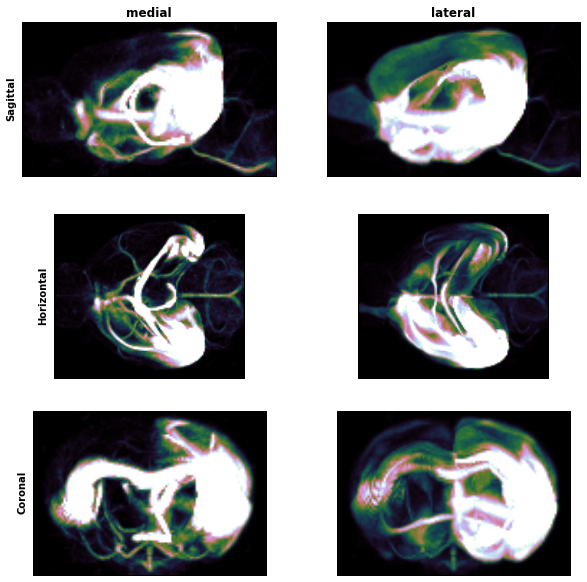

In [11]:
# Compare averaged projection patterns
plt.figure(figsize=(10,10))
clim = np.percentile(avg_grid_medial.flatten(),[1,99])
ylabels = ['Sagittal','Horizontal','Coronal']
for i in range(3):
    ax = plt.subplot(3,2,i*2+1)
    max_projection = np.max(avg_grid_medial,axis=i)
    if i == 2: max_projection = max_projection.T
    ax.imshow(max_projection,cmap=cm.cubehelix,clim=clim)
    if i == 0: plt.title('medial',fontweight='bold')
    plt.ylabel(ylabels[i],fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    
clim = np.percentile(avg_grid_lateral.flatten(),[1,99])
for i in range(3):
    ax = plt.subplot(3,2,i*2+2)
    max_projection = np.max(avg_grid_lateral,axis=i)
    if i == 2: max_projection = max_projection.T
    ax.imshow(max_projection,cmap=cm.cubehelix,clim=clim)
    if i == 0: plt.title('lateral',fontweight='bold')
    plt.xticks([])
    plt.yticks([])

***The cell below plots the average projection for the difference in average grid expression data in sagittal, horizontal, and coronal sections. This conceptually highlights the differences between the two columns plotted above.***

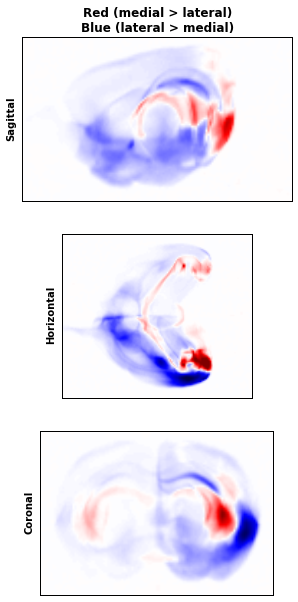

In [12]:
# Subtract the left plots from the right plots above to highlight differences
avg_diff = avg_grid_medial-avg_grid_lateral
clim = np.percentile(avg_diff.flatten(),[1,99])
clim = [-max(abs(clim)), max(abs(clim))]
    
plt.figure(figsize=(10,10))
for i in range(3):
    ax = plt.subplot(3,1,i+1)
    projection = np.mean(avg_diff,axis=i)
    if i == 2: projection = projection.T
    ax.imshow(projection,cmap=cm.seismic,clim=clim)
    if i == 0: plt.title('Red (medial > lateral)\nBlue (lateral > medial)',fontweight='bold')
    plt.ylabel(ylabels[i],fontweight='bold')
    plt.xticks([])
    plt.yticks([])

***The cell below produces a movie, showing coronal projections of all experiments, organized by the injection coordinates. The beginning shows experiments with LEC injections; later frames show progressively medial projections. The color slowly changes from yellow to cyan as the injections move from LEC to MEC.***


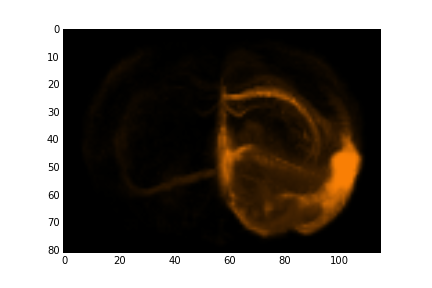
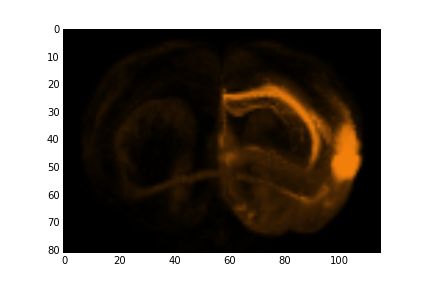
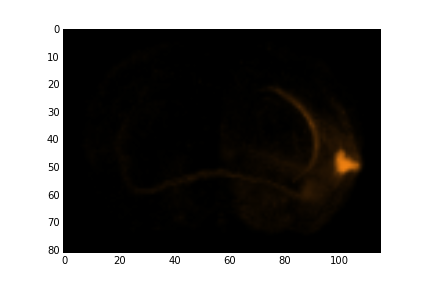
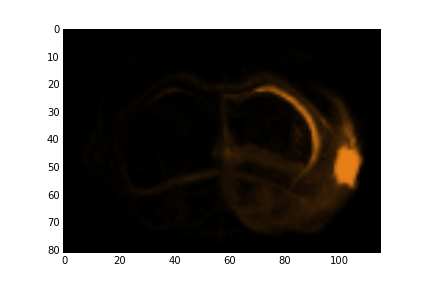
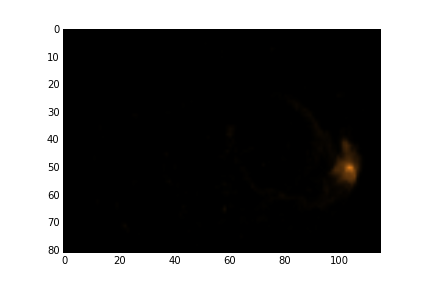
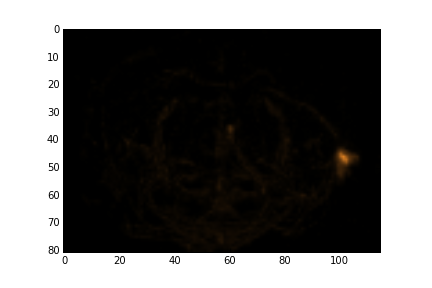
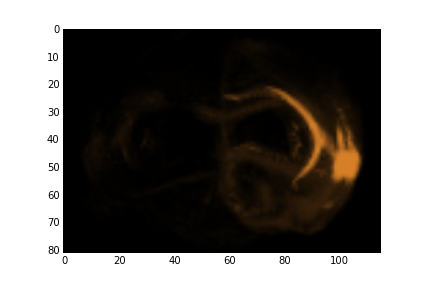
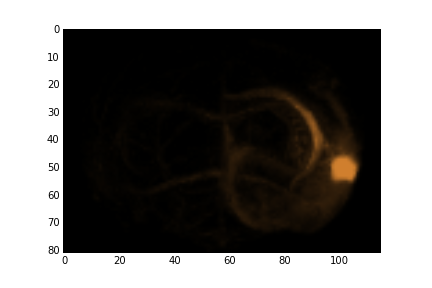
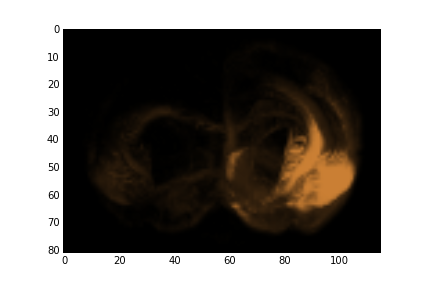
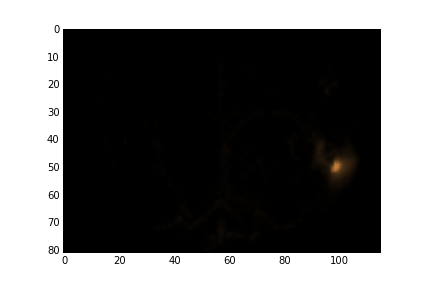
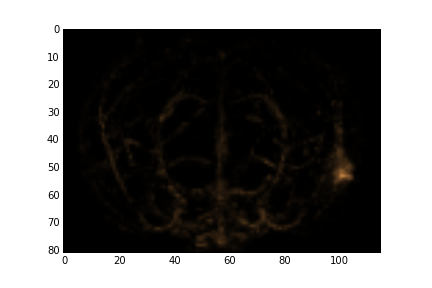
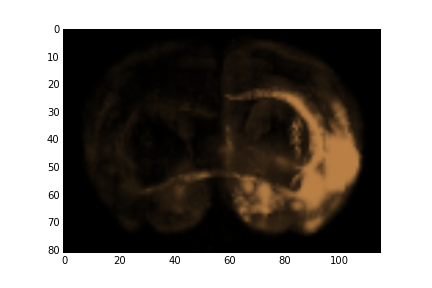
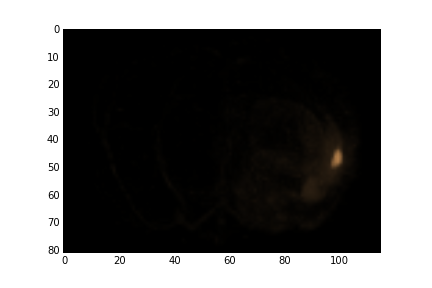
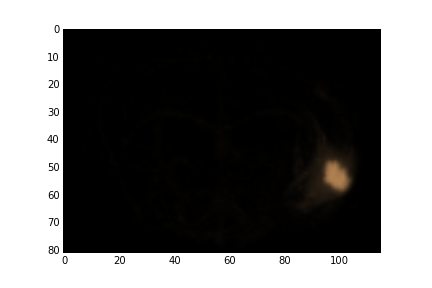
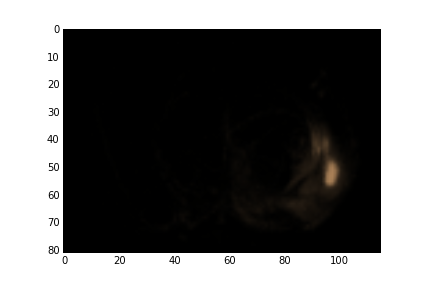
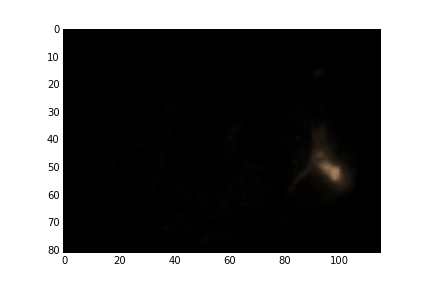
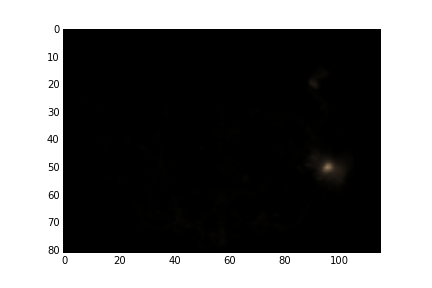
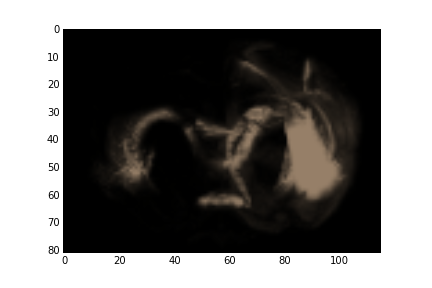
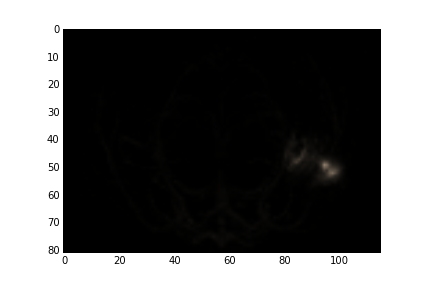
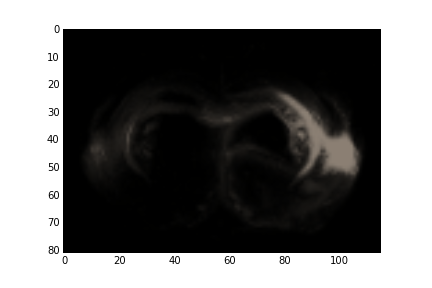
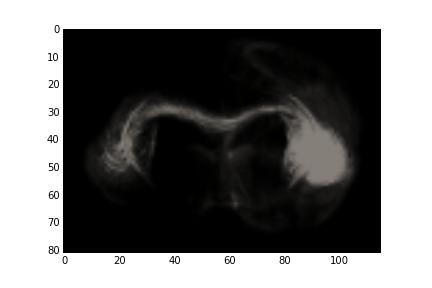
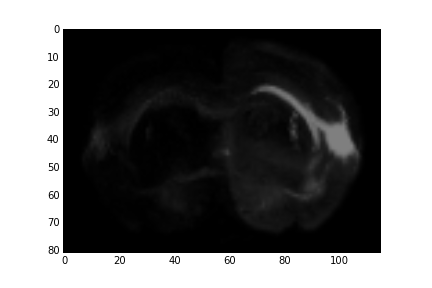
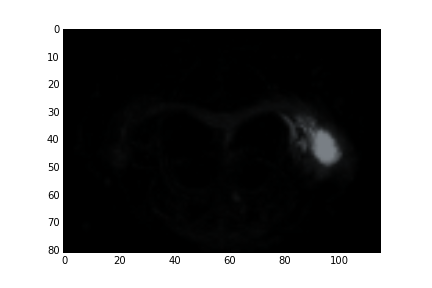
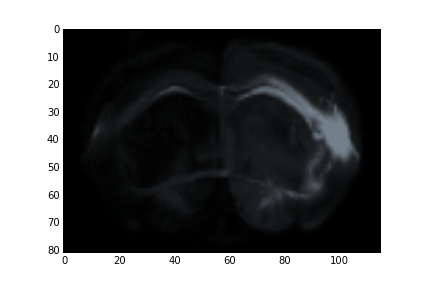
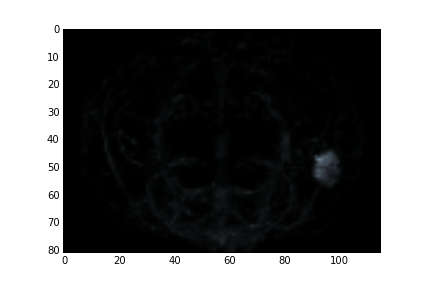
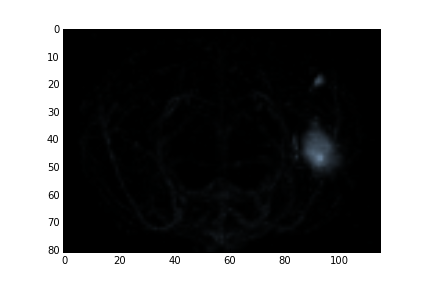
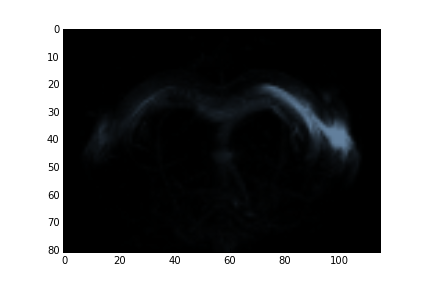
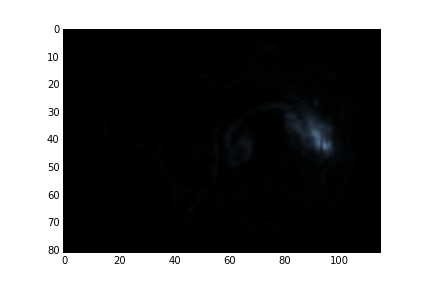
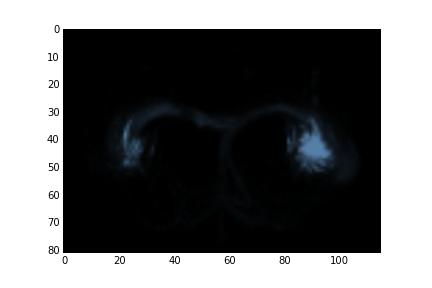
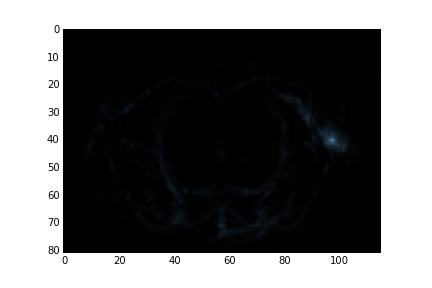
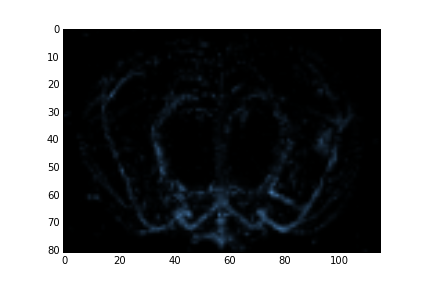
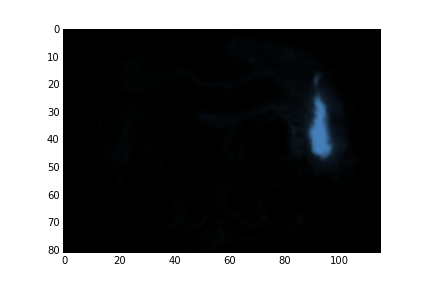
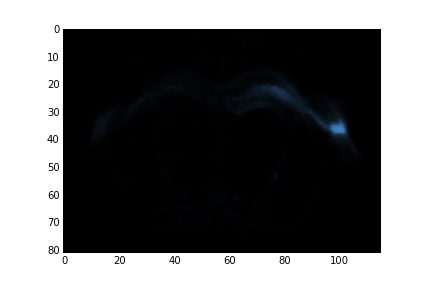
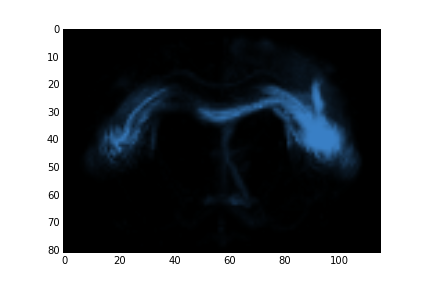
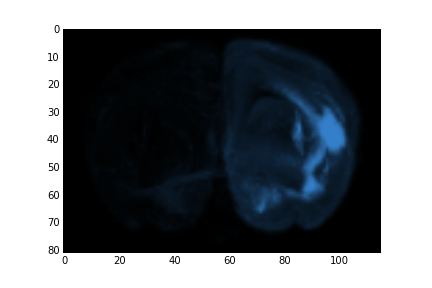
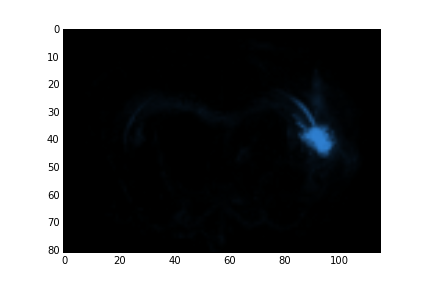
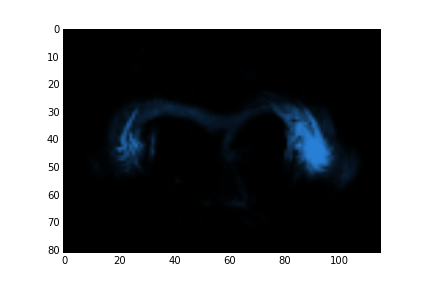
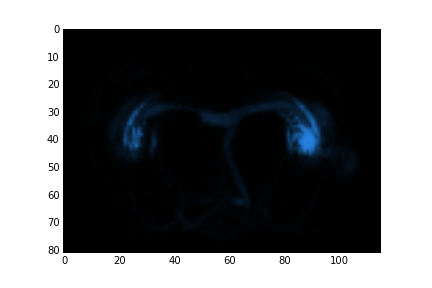
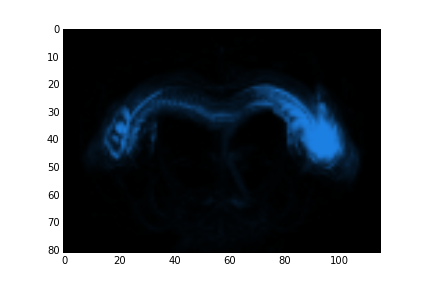
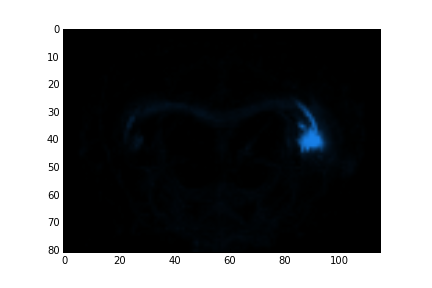
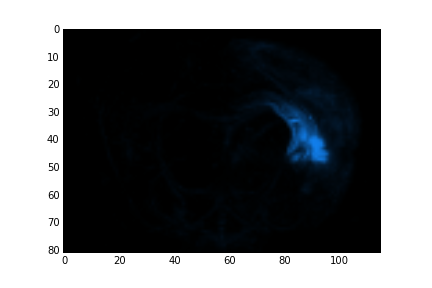
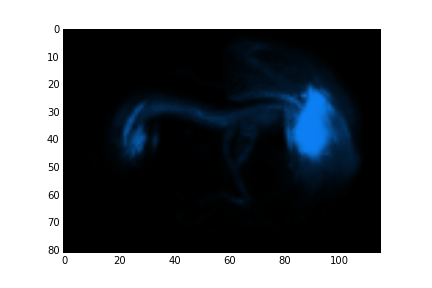
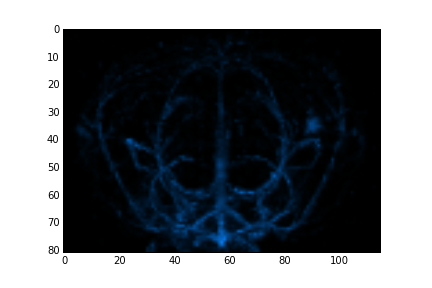
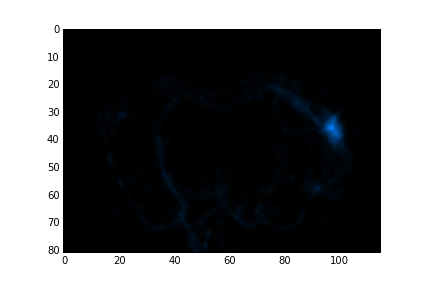

In [13]:
# Animation to show stack of images
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.colors import LinearSegmentedColormap

# Animation function
def animate(i):
    data = all_grid_data[:,:,:,lm_order[i]]
    coronal_projection = np.max(data,axis=2).T
    
    F = (len(lm_order) - (i+1)) / len(lm_order)
    
    cdict = {'red': ((0.0, 0.0, 0.0),
                     (1.0, F, 1.0)),
        
             'green': ((0.0, 0.0, 0.0),
                       (1.0, 0.5, 0.0)),
             
             'blue':  ((0.0, 0.0, 0.0),
                       (1.0, 1-F, 0.0))}
    temp_cmap = LinearSegmentedColormap('temp',cdict)
    animax.imshow(coronal_projection,cmap=temp_cmap)

animfig = plt.figure()
animax = plt.subplot(111)
animation.FuncAnimation(animfig, animate, frames=len(lm_order), interval=400, blit=False)

***The above movie shows considerable variability from experiment to experiment. To pick out more general trends, we used a moving average of experiments with nearby injection sites. Averaging over 5 experiments produces the following movie.***


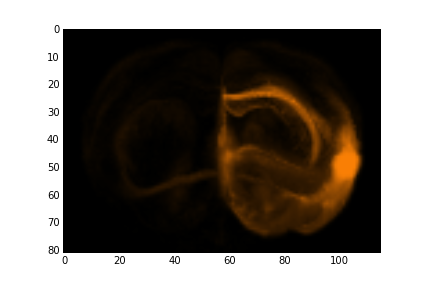
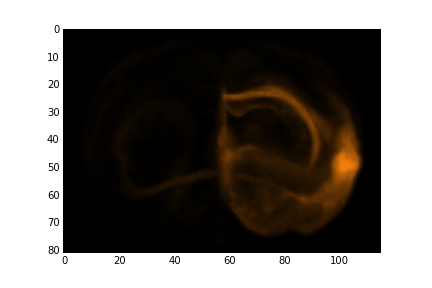
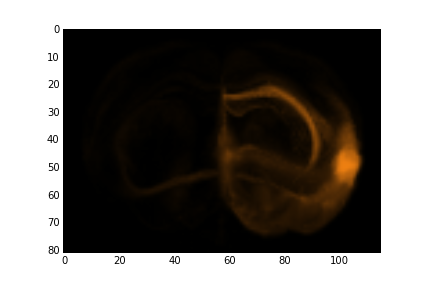
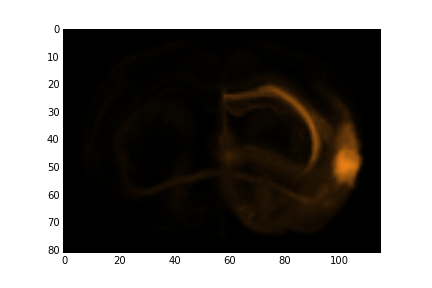
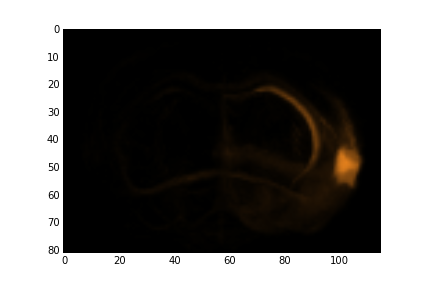
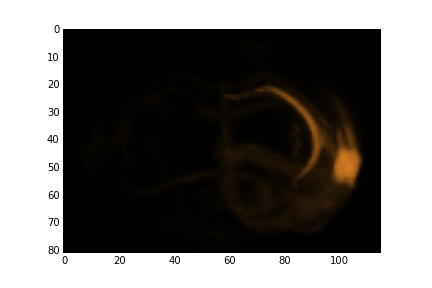
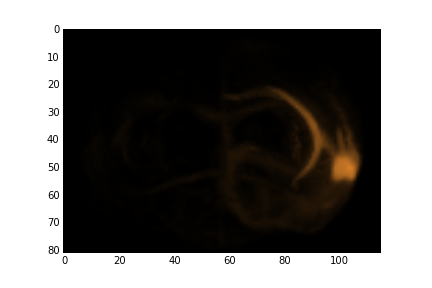
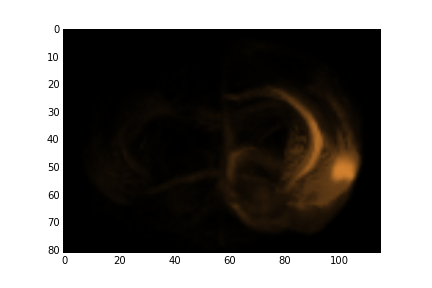
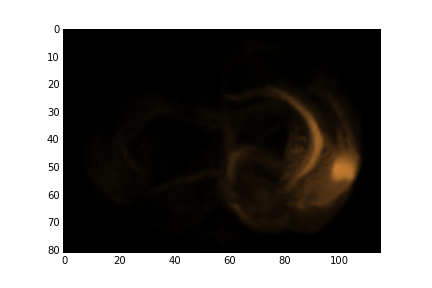
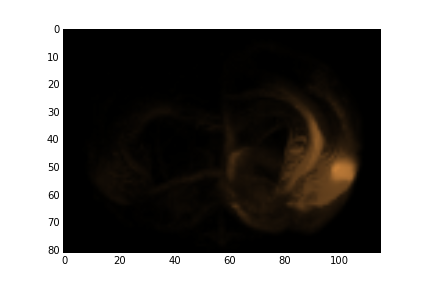
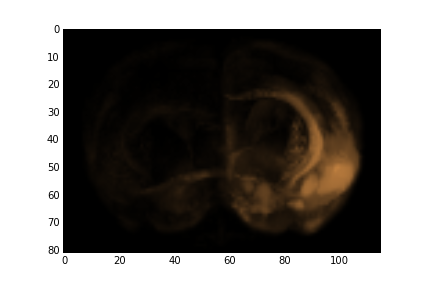
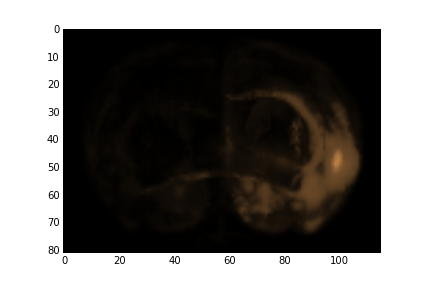
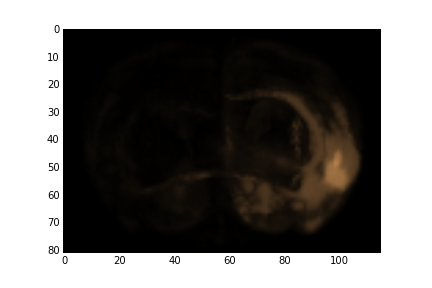
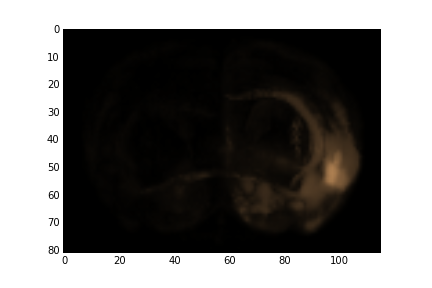
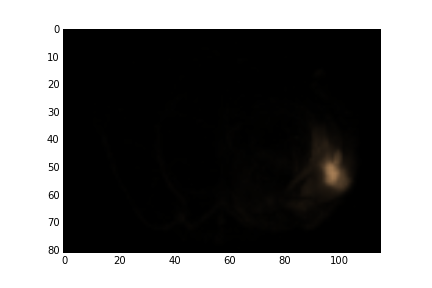
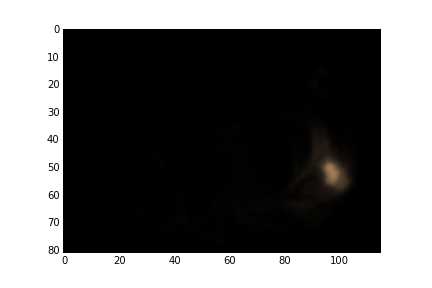
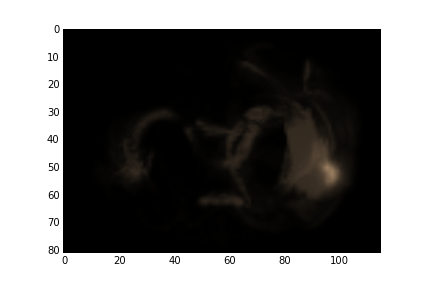
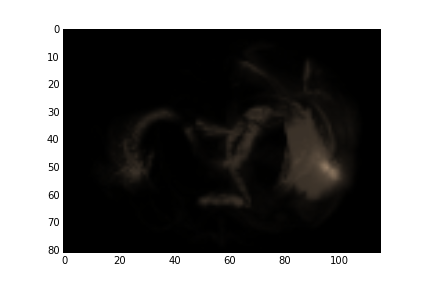
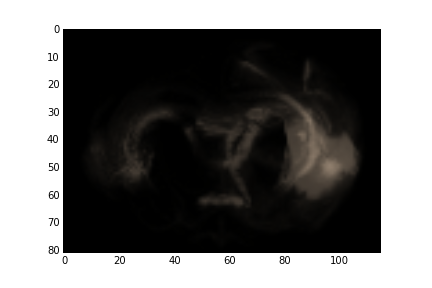
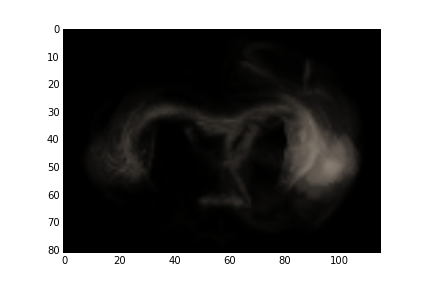
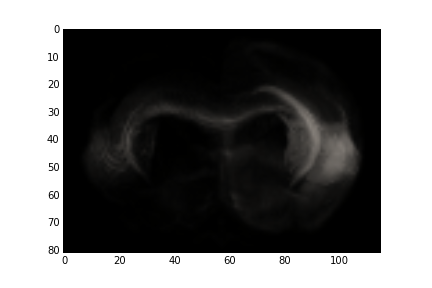
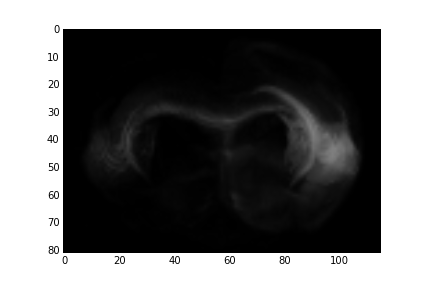
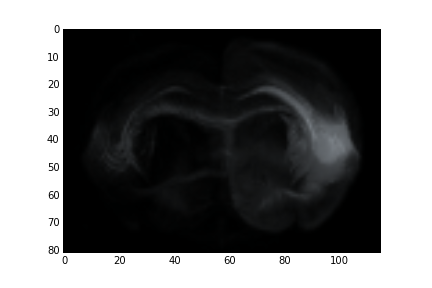
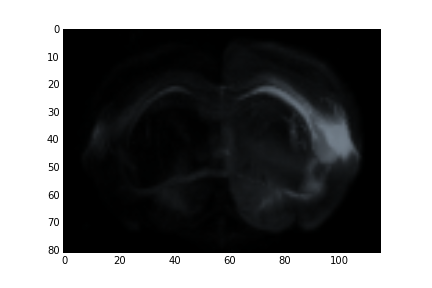
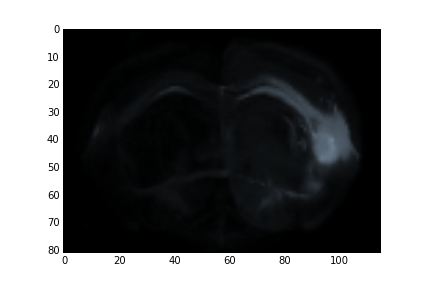
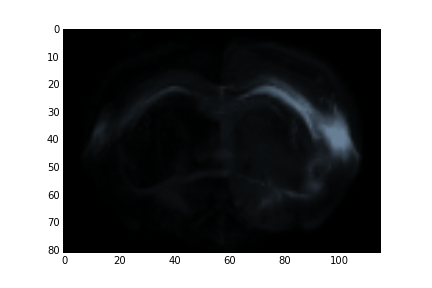
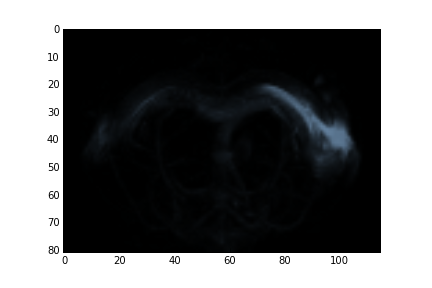
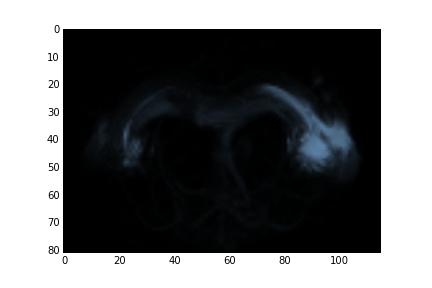
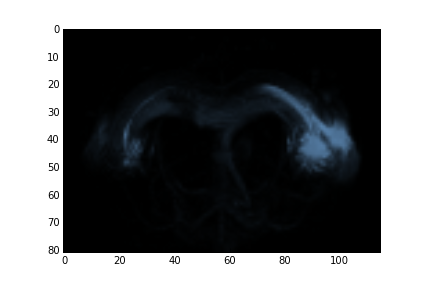
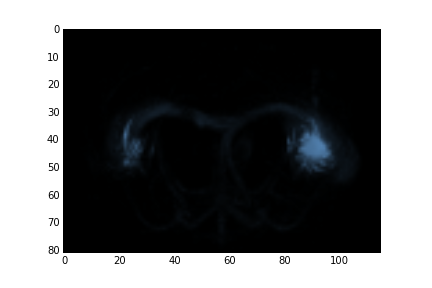
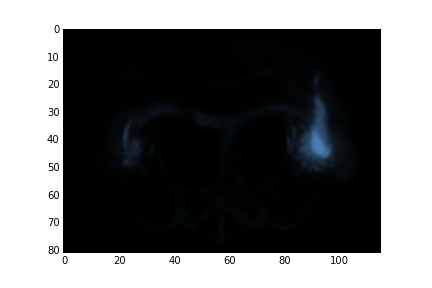
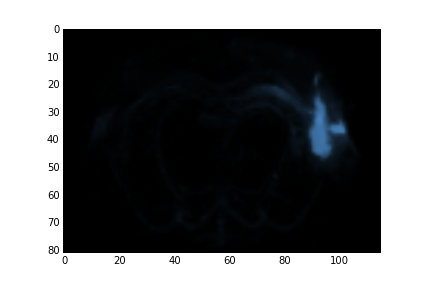
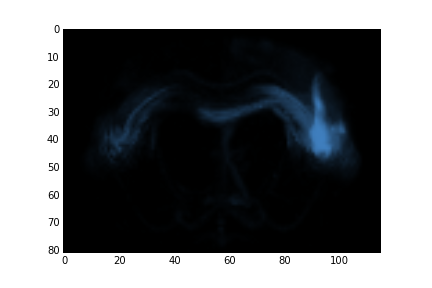
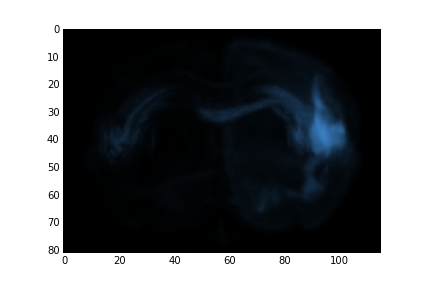
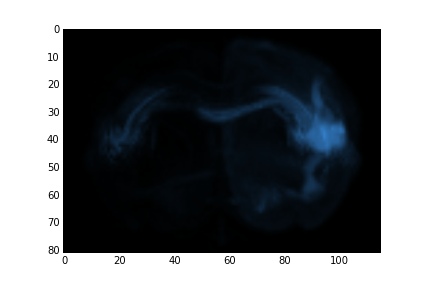
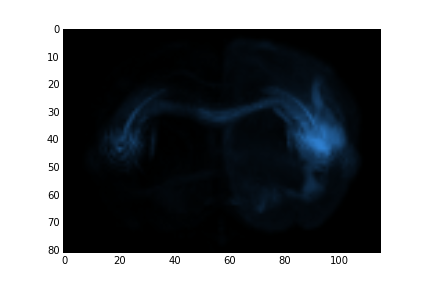
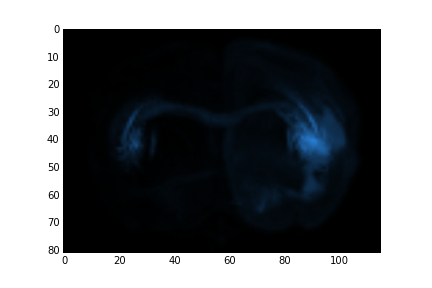
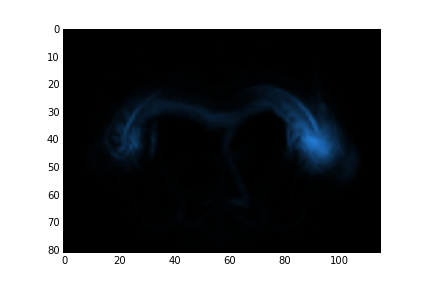
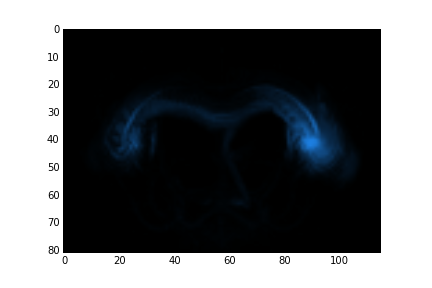
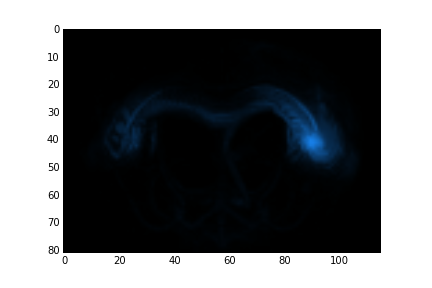
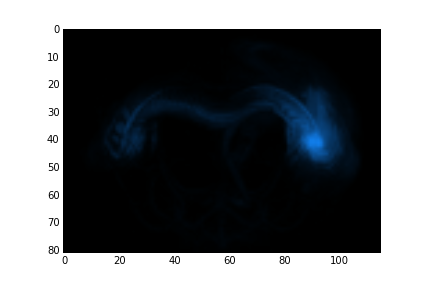
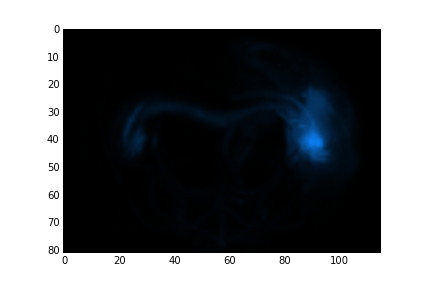
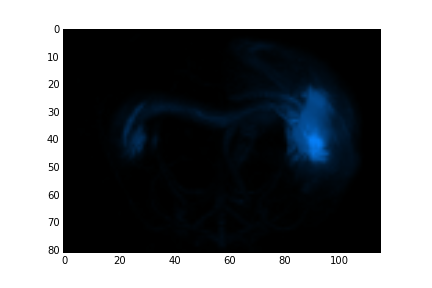
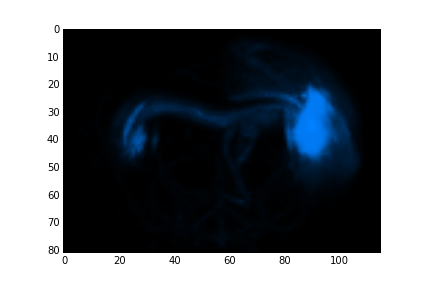

In [14]:
# Animation to show stack of images
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.colors import LinearSegmentedColormap

# Animation function -- moving average image
def animate(i):
    s,e = max([i-2,0]),min([i+2,len(lm_order)-1])
    data_indices = lm_order[s:e]
    data = all_grid_data[:,:,:,data_indices]
    mean_data = np.mean(data,axis=3)
    coronal_projection = np.max(mean_data,axis=2).T
    
    F = (len(lm_order) - (i+1)) / len(lm_order)
    
    cdict = {'red': ((0.0, 0.0, 0.0),
                     (1.0, F, 1.0)),
        
             'green': ((0.0, 0.0, 0.0),
                       (1.0, 0.5, 0.0)),
             
             'blue':  ((0.0, 0.0, 0.0),
                       (1.0, 1-F, 0.0))}
    temp_cmap = LinearSegmentedColormap('temp',cdict)
    animax.imshow(coronal_projection,cmap=temp_cmap)

animfig = plt.figure()
animax = plt.subplot(111)
animation.FuncAnimation(animfig, animate, frames=len(lm_order), interval=250, blit=False)